French Road Accidents
==============
## __Machine learning models for binary classification__

**Authors**:
> - Pablo Galán de Anta
> - Jennifer Pohlsen
> - Ilinca Suciu

**Project supervisor**: Lucas Varela - DataScientest

**Date**: 2023-12-08

## Table of Contents
1. [Load modules](#1.-Load-modules)
2. [Pre-processing](#2.-Pre-processing)
3. [Logistic Regression](#3.-Logistic-Regression)
4. [Random Forest](#4.-Random-Forest)
5. [Naïve-Bayes](#5.-Naïve-Bayes)
6. [XGBoost](#6.-XGBoost)
7. [Dense Neural Network (DNN)](#7.-Dense-Neural-Network-(DNN))


## __1. Load modules__

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
import time
import joblib
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency

## __2. Pre-processing__

We just focus on years 2019-2022 so we open those datasets

In [13]:
# Year selector
def year_selector(year):
    import glob
    list = glob.glob('../data/accidents_*.csv')
    list = sorted(list)
    list_of_years = []
    for jj in list:
        list_of_years.append(int(jj[18:22]))
    list_of_years = np.array(list_of_years)
    file_list = np.array(list)[list_of_years >= year]
    
    # Initialize an empty list to store individual DataFrames
    dfs = []
    
    # Iterate through the filtered file list and read each CSV file into a DataFrame
    for file_path in file_list:
        df = pd.read_csv(file_path)
        dfs.append(df)
    
    # Concatenate all the DataFrames into a single DataFrame
    concatenated_df = pd.concat(dfs, ignore_index=True)
    return concatenated_df

df = year_selector(2019)

df.head()

,Unnamed: 0.1,Num_Acc,place,catu,severity,gender,trajet,secu,locp,actp,...,int,atm,col,com,adr,gps,lat,long,dep,age
0,2167274,201900000001,2.0,2.0,1.0,2.0,0.0,NaN,-1.0,-1,...,1,1,2,93053,AUTOROUTE A3,NaN,48.896210,2.470120,93,17.0
1,2167275,201900000001,1.0,1.0,1.0,2.0,5.0,NaN,-1.0,-1,...,1,1,2,93053,AUTOROUTE A3,NaN,48.896210,2.470120,93,26.0
2,2167276,201900000001,1.0,1.0,0.0,1.0,0.0,NaN,-1.0,-1,...,1,1,2,93053,AUTOROUTE A3,NaN,48.896210,2.470120,93,60.0
3,2167277,201900000002,1.0,1.0,1.0,2.0,0.0,NaN,-1.0,-1,...,1,1,6,93066,AUTOROUTE A1,NaN,48.930700,2.368800,93,25.0
4,2167278,201900000003,1.0,1.0,0.0,1.0,0.0,NaN,-1.0,0,...,1,1,4,92036,AUTOROUTE A86,NaN,48.935872,2.319174,92,23.0


In [14]:
# Droping some columns
cols_to_drop = ['nbv', 'larrout', 'voie', 'adr']
df.drop(columns=cols_to_drop, axis=1, inplace=True)

In [15]:
length = len(df)
thres  = 0.9 # Threshold above which we delete columns
cols   = df.columns.values # Getting the columns
idx    = df.isna().sum().values/length < thres # Deleting conditions
df_cleaned = df[cols[idx]] # Purging all columns with % nulls above 90%

# We also dropna on lat and long
df_cleaned.dropna(inplace=True)

/tmp/ipykernel_6782/459690665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(inplace=True)


In [16]:
df_cleaned['severity'][df_cleaned['severity'] > 0.0] = 1.0 # Turning severity categories into a binary distribution

# Converting 'actp' 'A' and 'B' categories into numbers
df_cleaned['actp'][df_cleaned['actp'] == 'A'] = '10'
df_cleaned['actp'][df_cleaned['actp'] == 'B'] = '11'
df_cleaned['actp'] = df_cleaned['actp'].astype('int64')

# Discarding the 0 in 'gender' column
df_cleaned = df_cleaned[df_cleaned['gender'] != 0]

/tmp/ipykernel_6782/542744725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['severity'][df_cleaned['severity'] > 0.0] = 1.0 # Turning severity categories into a binary distribution
/tmp/ipykernel_6782/542744725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['actp'][df_cleaned['actp'] == 'A'] = '10'
/tmp/ipykernel_6782/542744725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['actp'][df_cl

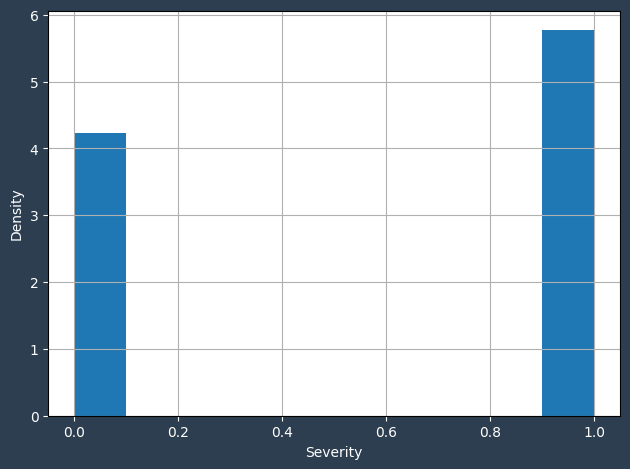

In [17]:
# Let's check the severity distribution after considering just two categories
fig, ax = plt.subplots(1,1)
df_cleaned['severity'].hist(density=True, ax=ax)
ax.set_xlabel('Severity', color='white')
ax.set_ylabel('Density', color='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='x', colors='white')
# Set a dark gray background color for the area with labels and title
fig.patch.set_facecolor('#2c3e50')  
plt.tight_layout()
plt.savefig("../plots/injury_sev_2cats.png", bbox_inches='tight', dpi = 150)

In [18]:
# Set the threshold for variance
threshold = 0.01

# Extract numerical columns from merge_cleaned (assuming merge_cleaned is a DataFrame containing numeric columns)
numeric_columns = df_cleaned.select_dtypes(include=['number'])

# Initialize VarianceThreshold selector
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the data using the selector
selected_features = selector.fit_transform(numeric_columns)

# Get the columns that are selected
selected_columns = numeric_columns.columns[selector.get_support()]

# Create a new DataFrame with selected features
df_cleaned = pd.DataFrame(data=selected_features, columns=selected_columns)

# Transform into str the Num_Acc column
df_cleaned['Num_Acc'] = df_cleaned['Num_Acc'].astype('int64').astype('str')

In [19]:
# Preparing the features matrix by deleting more features
cols_to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
df_cleaned.drop(columns=cols_to_drop, axis=1, inplace=True)

In [20]:
# Converting object type columns into integers
cols = ['place', 'catu', 'severity', 'gender', 'trajet', 'locp', 'comp', 'age', 'secu1',
        'secu2', 'secu3', 'catr', 'circ', 'vosp', 'surf', 'infra', 'situ', 'vma', 'actp',
       'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor', 'v1', 'prof', 'plan', 'month',
       'day', 'lum', 'agg', 'atm', 'col', 'int']
for ii in cols:
    df_cleaned[ii] = df_cleaned[ii].astype('int64')

In [21]:
df_cleaned.dtypes # Check the types of the variables

Num_Acc      object
place         int64
catu          int64
severity      int64
gender        int64
trajet        int64
locp          int64
actp          int64
comp          int64
secu1         int64
secu2         int64
secu3         int64
senc          int64
catv          int64
obs           int64
obsm          int64
choc          int64
manv          int64
motor         int64
catr          int64
v1            int64
circ          int64
vosp          int64
prof          int64
plan          int64
surf          int64
infra         int64
situ          int64
vma           int64
year        float64
month         int64
day           int64
lum           int64
agg           int64
int           int64
atm           int64
col           int64
lat         float64
long        float64
age           int64
dtype: object

In [22]:
# Deleting category -1 in 'gender'
df_cleaned = df_cleaned[df_cleaned['gender'] != -1]

# Check how many variables present just two categories
two_categories = df_cleaned.columns[df_cleaned.nunique() == 2]

# Displaying columns with just two categories for encoding
print("Columns with just two categories:")
print(two_categories)

Columns with just two categories:
Index(['severity', 'gender', 'agg'], dtype='object')


In [23]:
# Encoding gender and agg
df_cleaned['gender'][df_cleaned['gender'] == 2] = 0
df_cleaned['agg'][df_cleaned['agg'] == 2] = 0

#### Pre-processing secu1, 2, 3 variables

In [24]:
new_secu  = df_cleaned#[['Num_Acc', 'secu1', 'secu2', 'secu3']]
new_secu[['secu1', 'secu2', 'secu3']] = new_secu[['secu1', 'secu2', 'secu3']].astype('str')
new_secu = pd.get_dummies(new_secu, columns=['secu1', 'secu2', 'secu3'])
new_secu = new_secu.drop(['secu1_-1', 'secu1_0', 'secu2_0', 'secu3_0', 'secu2_-1', 'secu3_-1'], axis =1) # discard unnecessary dummies
for suffix in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
        var_name1 = 'secu1_' + suffix
        var_name2 = 'secu2_' + suffix
        var_name3 = 'secu3_' + suffix
       # print(var_name1, '; ', var_name2, '; ', var_name3)
        new_secu['secu_' + suffix] = new_secu[var_name1] + new_secu[var_name2] + new_secu[var_name3] # create new unique variable for the category
        new_secu = new_secu.drop([var_name1, var_name2, var_name3], axis = 1) # drop old variables of that category

# Check new security variables
#new_secu.head()


# 4. Optional rename columns ... according to the type of security they're coding for
col_mapping = {
    'secu1_-2' : 'secu_absent',
    'secu1_-3': 'secu_NA',
    'secu_1': 'secu_belt',
    'secu_2': 'secu_helmet',
    'secu_3': 'secu_child-restraint',
    'secu_4': 'secu_reflective-vest',
    'secu_5': 'secu_airbag',
    'secu_6': 'secu_gants',
    'secu_7': 'secu_airbag-gants',
    'secu_8': 'secu_undet',
    # secu_undet = undeterminable, probably in severe accidents;
    # in which case I suggest removing it (because it depend on accident severity, and not the other way around)
    'secu_9': 'secu_other'
}

cols = ['secu_absent', 'secu_NA', 'secu_belt', 'secu_helmet', 'secu_child-restraint', 'secu_reflective-vest',
       'secu_airbag', 'secu_gants', 'secu_airbag-gants', 'secu_undet']
new_secu = new_secu.rename(columns = col_mapping)


# 5. Replace values of '2' and '3' with '1'
new_secu.info()
new_secu[cols] = new_secu[cols].replace({2.0: 1,
                             3.0 : 1})

# Check that there are no additional otliers present (i.e. values consist exclusively of '0' and '1')
new_secu.describe()

# NOTE: the new_secu dataframe needs to be now merged with the dataframe it originated from, where secu_1, secu_2 and secu_3 variables will be dropped.
#df_cleaned = df_cleaned.drop(['secu1', 'secu2', 'secu3'], axis = 1)
# merge_02['Num_Acc'] = merge_02['Num_Acc'].astype(object)
#df_cleaned = df_cleaned.merge(new_secu, left_on=['Num_Acc'], right_on=['Num_Acc'])
df_cleaned = new_secu
del new_secu

df_cleaned.drop('Num_Acc', axis=1, inplace=True)

# 6. Check correlations between the newly constructed security variables

#secu_and_sev = list(merge_cleaned.loc[:,'secu_absent':'secu_other'].columns)
#secu_and_sev.append('severity')
#print(secu_and_sev)

#plt.figure(figsize = (10,8))
#sns.heatmap(merge_cleaned.loc[merge_cleaned['year'].isin([2019, 2020, 2021, 2022]), 
#                              merge_cleaned.columns.isin(secu_and_sev)].corr(), 
#            cmap = 'bwr', center = 0, annot = True, fmt = ".2f");
#del secu_and_sev

<class 'pandas.core.frame.DataFrame'>
Index: 442796 entries, 0 to 442799
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Num_Acc               442796 non-null  object 
 1   place                 442796 non-null  int64  
 2   catu                  442796 non-null  int64  
 3   severity              442796 non-null  int64  
 4   gender                442796 non-null  int64  
 5   trajet                442796 non-null  int64  
 6   locp                  442796 non-null  int64  
 7   actp                  442796 non-null  int64  
 8   comp                  442796 non-null  int64  
 9   senc                  442796 non-null  int64  
 10  catv                  442796 non-null  int64  
 11  obs                   442796 non-null  int64  
 12  obsm                  442796 non-null  int64  
 13  choc                  442796 non-null  int64  
 14  manv                  442796 non-null  int64  
 15  motor

### Dummyfication using correlation matrix

In [25]:
# Correlation matrix
#corr = df_cleaned.corr()

# Creating a mask to discard correlations with severity below |0.05|
#idx = (corr['severity'] >= 0.005) | (corr['severity'] <= -0.005)

# Applying the mask to the dataset
#df_cleaned = df_cleaned[df_cleaned.columns[idx].values]

In [26]:
# List of columns to convert into dummy without gender and agg
cols_to_dummy = df_cleaned.columns.difference(['gender', 'agg', 'age', 'severity', 'birth_year', 'year', 'secu_absent',
                                              'secu_NA', 'secu_belt', 'secu_helmet', 'secu_child-restraint', 'secu_reflective-vest',
                                              'secu_airbag', 'secu_gants', 'secu_airbag-gants', 'secu_undet', 'secu_other', 'lat', 'long'])

# Convert the columns into variable dummies
df_cleaned = pd.get_dummies(df_cleaned, columns=cols_to_dummy)

### Spliting in training and testing sets: rescaling of quantitative variables

In [27]:
X = df_cleaned.drop('severity', axis=1) # Features
y = df_cleaned['severity'] # Target

# Split the data based on the 'year' column to account for the dependence with time
#X_train = X[year < split_year]
#y_train = y[year < split_year]
#X_test = X[year >= split_year]
#y_test = y[year >= split_year]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

Text(0.5, 1.0, 'Histogram of Longitude')

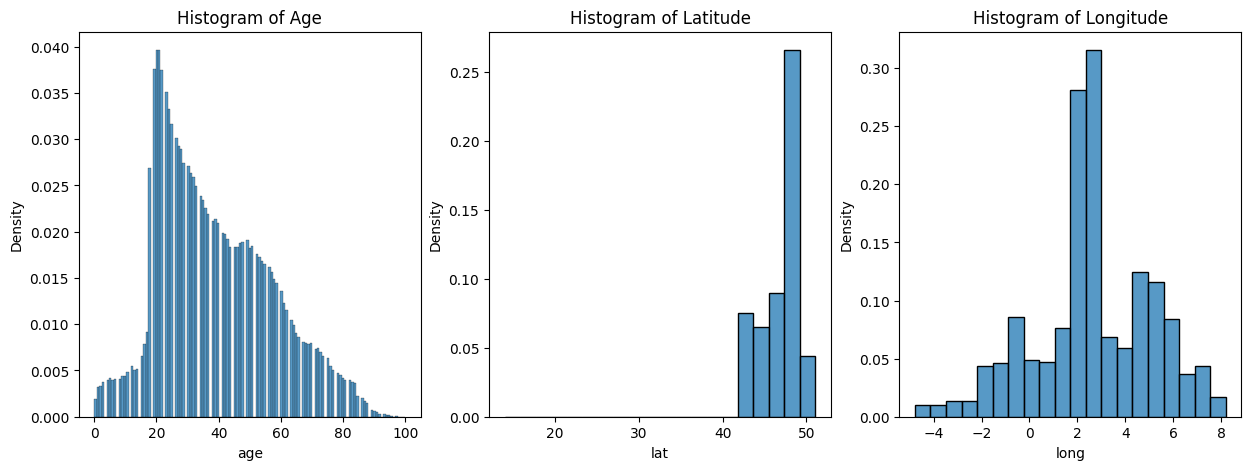

In [28]:
# Before scaling the variables, let's take a look at their distributions
# Histograms of the variables age, lat, and long
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.ravel()
sns.histplot(X_train["age"], stat="density", ax=ax[0])
sns.histplot(X_train["lat"], bins=20, stat="density", ax=ax[1])
sns.histplot(X_train["long"], bins=20, stat="density", ax=ax[2])
ax[0].set_title("Histogram of Age")
ax[1].set_title("Histogram of Latitude")
ax[2].set_title("Histogram of Longitude")

# The age does not follow a normal distirbution, so it is recommended to use the MinMax scaler.
# For latitude and longitude, we can use the standard scaler

In [29]:
# Extract the 'birth_year' and 'year' columns from X_train and X_test
# Extract the columns to be scaled
columns_to_scale_minmax = ['year', 'age']
columns_to_scale_standard = ['lat', 'long']

# Initialize the scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Fit and transform the MinMax scaler on the specified columns
X_train[columns_to_scale_minmax] = minmax_scaler.fit_transform(X_train[columns_to_scale_minmax])
# Transform the 'year' and 'age' columns using the MinMax scaler fitted on the training set
X_test[columns_to_scale_minmax] = minmax_scaler.transform(X_test[columns_to_scale_minmax])

# Fit and transform the Standard scaler on the specified columns
X_train[columns_to_scale_standard] = standard_scaler.fit_transform(X_train[columns_to_scale_standard])
# Transform the 'lat' and 'long' columns using the Standard scaler fitted on the training set
X_test[columns_to_scale_standard] = standard_scaler.transform(X_test[columns_to_scale_standard])

### __Feature selection__

Let's use a Random forest classifier for the importance features. Then we use the Logistic Regression to check how the goodness of our model varies with the number of variables to further decide how many variables we will use. This will significantly reduce the computation time while preserving the accuracy of our model.

In [30]:
# Instantiating and fitting the Random Forest Classifier on the training set
rf = RandomForestClassifier(n_jobs=6)
rf.fit(X_train, y_train)

# Getting the importance of each feature
importance = rf.feature_importances_

dim = X_train.shape[1]  # Dimension of the original training set

print('Initial dimension:', dim)

prec_list, recall_list, f1_list, dimension_list = [], [], [], []

def process_threshold(thres, X_train, y_train, X_test, y_test, importance):
    idx = importance >= thres

    X_train_aux = X_train.iloc[:, idx]  # Reassigning the training set columns
    X_test_aux = X_test.iloc[:, idx]  # Reassigning the test set columns

    dim_aux = X_train_aux.shape[1]  # Dimension of the original training set
    dimension_list.append(dim_aux)

    # Instantiating the logistic regression
    lr = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000)
    lr.fit(X_train_aux, y_train)

    # Predictions
    y_pred = lr.predict(X_test_aux)

    # Classification report
    class_names = ['0', '1']
    report = classification_report_imbalanced(y_test, y_pred, target_names=class_names, output_dict=True)

    # Precision
    prec_list.append([report['0']['pre'], report['1']['pre']])
    # Recall
    recall_list.append([report['0']['rec'], report['1']['rec']])
    # F1-score
    f1_list.append([report['0']['f1'], report['1']['f1']])

    return dim_aux, prec_list, recall_list, f1_list

step = np.logspace(-6, -1.3, 100)

# Use joblib to parallelize the for loop
dimensions, precisions, recalls, f1_scores = zip(*Parallel(n_jobs=6)(delayed(process_threshold)(thres, X_train, y_train, X_test, y_test, importance) for thres in tqdm(step)))

prec, recall, f1 = np.array(precisions), np.array(recalls), np.array(f1_scores)

Initial dimension: 362


100%|█████████████████████████████████████████| 100/100 [13:26<00:00,  8.06s/it]


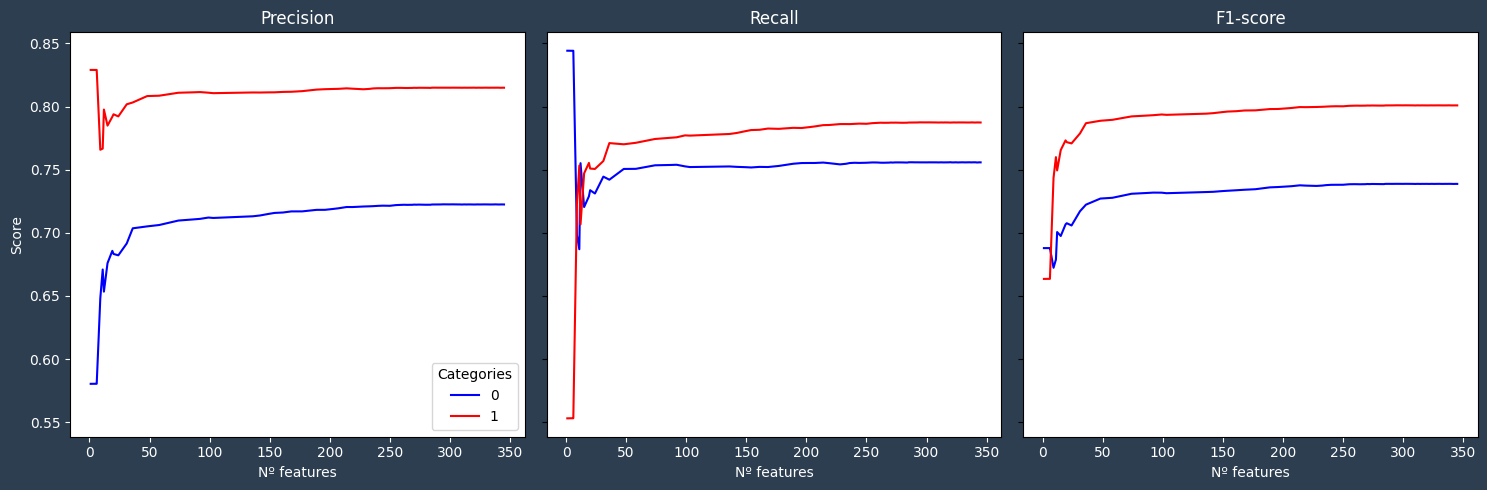

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,5),sharey=True)
ax = ax.ravel()

# Precision
ax[0].plot(dimensions, prec[:,0][:,0], 'b-', label='0')
ax[0].plot(dimensions, prec[:,0][:,1], 'r-', label='1')

# Recall
ax[1].plot(dimensions, recall[:,0][:,0], 'b-')
ax[1].plot(dimensions, recall[:,0][:,1], 'r-')

# F1-score
ax[2].plot(dimensions, f1[:,0][:,0], 'b-')
ax[2].plot(dimensions, f1[:,0][:,1], 'r-')

# Labels
ax[0].legend(loc='best', title="Categories")
ax[0].set_xlabel('Nº features', color='white'); ax[1].set_xlabel('Nº features', color='white'); ax[2].set_xlabel('Nº features', color='white')
ax[0].set_ylabel('Score', color='white')
ax[0].set_title('Precision', color='white'); ax[1].set_title('Recall', color='white'); ax[2].set_title('F1-score', color='white')

ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='x', colors='white')
ax[2].tick_params(axis='x', colors='white')

# Set a dark gray background color for the area with labels and title
fig.patch.set_facecolor('#2c3e50')

plt.tight_layout()
plt.savefig('../plots/dimension_reduc.png',bbox_inches='tight', dpi = 150)

In [85]:
thres = step[abs(np.array(dimensions) - 200).argmin()] # Getting the threshold for 100 dimensions

idx = importance >= thres
    
X_train = X_train[X_train.columns[idx]] # Reassigning the training set columns
X_test  = X_test[X_test.columns[idx]] # Reassigning the training set columns

# Saving the training and tsting sets into csv files to not need to re-load the code every time
# Concatenate X_train and y_train into a single DataFrame
training_set = pd.concat([X_train, y_train], axis=1)
# Same for X_test and y_test
testing_set  = pd.concat([X_test, y_test], axis=1)

def split_and_save(set, name, num_parts = 4):
    # Splitting the dataset set into n-parts
    split_indices = [i * len(set) // num_parts for i in range(1, num_parts)]
    tt_set_parts = np.split(set, split_indices)
    
    # Saving each part into a separate file
    for i, part in enumerate(tt_set_parts):
        part.to_csv(f'../data/train_test_sets/{name}_set_parts_{i + 1}.csv', index=False)

# Testing sets
split_and_save(testing_set, 'testing', num_parts = 2)
# Training sets
split_and_save(training_set, 'training', num_parts = 8)

## __Opening training and testing sets__

In [38]:
import glob

# Training files
files = glob.glob('../data/train_test_sets/training_set_parts_*')
files = sorted(files)
training_set_parts = [pd.read_csv(file_path) for file_path in files]

# Concatenate the DataFrames into a single training set
training_set = pd.concat(training_set_parts, ignore_index=True)

# Testing files
files = glob.glob('../data/train_test_sets/testing_set_parts_*')
files = sorted(files)
testing_set_parts = [pd.read_csv(file_path) for file_path in files]

# Concatenate the DataFrames into a single training set
testing_set = pd.concat(testing_set_parts, ignore_index=True)

# Spliting in Features and Target
X_train, y_train = training_set.drop('severity', axis=1), training_set['severity']
X_test, y_test   = testing_set.drop('severity', axis=1), testing_set['severity']

## __3. Logistic Regression__

### Initial Logistic Regression model

In [87]:
# Instantiating the logistic regression
lr = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the best parameters, best accuracy, and other metrics if needed
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Logistic Regression Classification report:\n',class_report)

path_to_file = "../models/lr_ini_model"
print('Model saved at:',path_to_file)
joblib.dump(lr, path_to_file)

Cross-tab:
 Predicted      0      1
Actual                 
0          28272   9166
1          11058  40064

Logistic Regression Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.76      0.78      0.74      0.77      0.59     37438
          1       0.81      0.78      0.76      0.80      0.77      0.59     51122

avg / total       0.77      0.77      0.77      0.77      0.77      0.59     88560

Model saved at: ../models/lr_ini_model


['../models/lr_ini_model']

### Grid search cross-validation

In [3]:
# Instantiate the logistic regression
lr = LogisticRegression(max_iter=1000)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

# Instantiate GridSearchCV with scoring parameter
grid_search = GridSearchCV(lr, param_grid, scoring='recall', cv=5, n_jobs=10, verbose=2)  # Adjust the number of jobs for your computer

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to train the final model
best_lr = LogisticRegression(C=best_params['C'], solver=best_params['solver'], max_iter=1000)
best_lr.fit(X_train, y_train)

# Predictions
y_pred = best_lr.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate accuracy score on the test data
class_report = classification_report(y_test, y_pred)

# Print the best parameters, best accuracy, and other metrics if needed
print('=========================')
print("Best Parameters:", best_params)
print("\nCross-tab:\n", cross_tab)
print('\n=========================')
print('Logistic Regression Classification report:\n', class_report)

path_to_file = "../models/lr_improved_model"
print('Model saved at:',path_to_file)
joblib.dump(best_lr, path_to_file)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 0.001, 'solver': 'sag'}

Cross-tab:
 Predicted      0      1
Actual                 
0          29881  10100
1          11742  42981

Logistic Regression Classification report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.73     39981
           1       0.81      0.79      0.80     54723

    accuracy                           0.77     94704
   macro avg       0.76      0.77      0.76     94704
weighted avg       0.77      0.77      0.77     94704

[CV] END ..............................C=0.001, solver=lbfgs; total time=  16.7s
[CV] END ................................C=0.001, solver=sag; total time=   8.9s
[CV] END ...............................C=0.001, solver=saga; total time=  12.8s
[CV] END ...............................C=0.01, solver=lbfgs; total time=  39.7s
[CV] END .................................C=0.01, solver=sag; total time=  10.2s
[CV] 

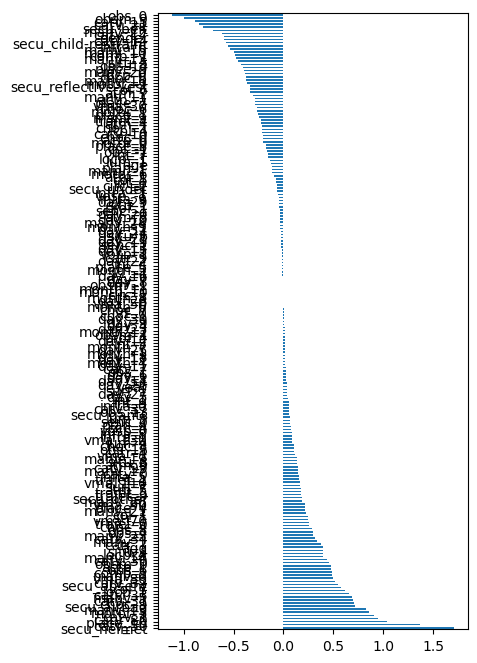

In [138]:
pd.Series(lr.coef_[0], X_train.columns).sort_values(
    ascending=False).plot(kind='barh', figsize=(4,8));
#plt.savefig('../Escritorio/importance.png',bbox_inches='tight', dpi = 150)

## __4. Random Forest__

### Initial Random Forest Classifier

In [90]:
rf = RandomForestClassifier(n_estimators = 300,
                            criterion = "entropy",
                            max_depth = 10,
                            min_samples_split = 5,
                            min_samples_leaf = 3,
                            n_jobs = 10)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Random Forest Classifier Classification report:\n',class_report)

path_to_file = "../models/rf_ini_model"
print('Model saved at:',path_to_file)
joblib.dump(rf, path_to_file)

Cross-tab:
 Predicted      0      1
Actual                 
0          28087   9351
1          11137  39985

Random Forest Classifier Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.75      0.78      0.73      0.77      0.58     37438
          1       0.81      0.78      0.75      0.80      0.77      0.59     51122

avg / total       0.77      0.77      0.76      0.77      0.77      0.59     88560

Model saved at: ../models/rf_ini_model


['../models/rf_ini_model']

### Grid search cross-validation

In [5]:
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500,
                            criterion="entropy",
                            max_depth=None,
                            min_samples_split=10,
                            min_samples_leaf=1,
                            n_jobs=6)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate GridSearchCV with scoring parameter set to 'recall' (or any other metric you prefer)
grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=3, verbose=2, n_jobs=2) # Adjust the number of jobs for your computer

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to train the final model
best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 min_samples_split=best_params['min_samples_split'],
                                 min_samples_leaf=best_params['min_samples_leaf'],
                                 n_jobs=10)
best_rf.fit(X_train, y_train)

# Predictions
y_pred = best_rf.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate accuracy score on the test data
class_report = classification_report(y_test, y_pred)

# Print the best parameters, confusion matrix (cross_tab), and classification report
print('=========================')
print("Best Parameters:", best_params)
print("\nCross-tab:\n", cross_tab)
print('\n=========================')
print('Random Forest Classifier Classification report:\n', class_report)

path_to_file = "../models/rf_improved_model"
print('Model saved at:',path_to_file)
joblib.dump(best_rf, path_to_file)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.7min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.6min


/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.6min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_es

## __5. Naïve-Bayes__

In [140]:
nb = GaussianNB(var_smoothing = 1e-06)
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Naive Bayes Classification report:\n',class_report)

Cross-tab:
 Predicted      0      1
Actual                 
0          35019   4962
1          23344  31379

Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.60      0.88      0.57      0.71      0.71      0.52     39981
          1       0.86      0.57      0.88      0.69      0.71      0.49     54723

avg / total       0.75      0.70      0.75      0.70      0.71      0.50     94704



For Naive Bayes, specifically Gaussian Naive Bayes, the parameter tuning is less common compared to models like Random Forest or Logistic Regression. Naive Bayes models, including Gaussian Naive Bayes, are generally not as sensitive to hyperparameter changes. It is not worth it to run `GridSearchCV` on this model.

## __6. XGBoost__

### Initial XGBoost model

In [8]:
# Instantiating XGboost
xgboost = XGBClassifier(n_estimators=1000, max_depth=6,
                           objective='binary:logistic', eval_metric="logloss",
                       use_label_encoder=False, random_state=222)
xgboost.fit(X_train, y_train)

# Predictions
y_pred = xgboost.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('XGboost Classification report:\n',class_report)

path_to_file = "../models/xgboost_ini_model"
print('Model saved at:',path_to_file)
joblib.dump(xgboost, path_to_file)

Cross-tab:
 Predicted      0      1
Actual                 
0          28570   8868
1           9360  41762

XGboost Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.76      0.82      0.76      0.79      0.62     37438
          1       0.82      0.82      0.76      0.82      0.79      0.63     51122

avg / total       0.79      0.79      0.79      0.79      0.79      0.62     88560

Model saved at: ../models/xgboost_ini_model


['../models/xgboost_ini_model']

### Grid search cross-validation

In [4]:
# Instantiate XGBoost
xgboost = XGBClassifier(n_estimators=1000, max_depth=6, objective='binary:logistic', eval_metric="logloss", use_label_encoder=False)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [1000],  # You can adjust these values based on your requirements
    'max_depth': [3, 6, 9],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Instantiate GridSearchCV with scoring parameter set to 'recall' (or any other metric you prefer)
grid_search = GridSearchCV(xgboost, param_grid, scoring='recall', cv=5, n_jobs=10, verbose=2) # Adjust the number of jobs for your computer

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to train the final model
best_xgboost = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective='binary:logistic',
    eval_metric="logloss"
)
best_xgboost.fit(X_train, y_train)

# Predictions
y_pred = best_xgboost.predict(X_test)

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate accuracy score on the test data
class_report = classification_report(y_test, y_pred)

# Print the best parameters, confusion matrix (cross_tab), and classification report
print('=========================')
print("Best Parameters:", best_params)
print("\nCross-tab:\n", cross_tab)
print('\n=========================')
print('XGBoost Classification report:\n', class_report)

path_to_file = "../models/xgboost_improved_model"
print('Model saved at:',path_to_file)
joblib.dump(best_xgboost, path_to_file)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1.0}

Cross-tab:
 Predicted      0      1
Actual                 
0          24086  15895
1           8564  46159

XGBoost Classification report:
               precision    recall  f1-score   support

           0       0.74      0.60      0.66     39981
           1       0.74      0.84      0.79     54723

    accuracy                           0.74     94704
   macro avg       0.74      0.72      0.73     94704
weighted avg       0.74      0.74      0.74     94704



### __Model interpretation__

We will use either Skater and Lime to check how the features affect the two categories in our target matrix 'severity'.

- #### SKATER

In [93]:
# Training parameters (the parameters are obtained from the GridSearchCV section of XGboosts)
params = {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 1.0,
         'objective': 'binary:logistic', 'eval_metric': "logloss"}

# Conversion of datasets to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Model training
bst = xgb.train(params, dtrain, 1000)

probs = bst.predict(dtest)
preds = [0 if x < 0.5 else 1 for x in probs]

print(classification_report(y_test, preds))

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_train, feature_names=X_train.columns)

def predict_xg(x):
    return pd.DataFrame(bst.predict(xgb.DMatrix(x)))

model = InMemoryModel(predict_xg, examples=X_train)

              precision    recall  f1-score   support

           0       0.75      0.55      0.63     37438
           1       0.72      0.87      0.79     51122

    accuracy                           0.73     88560
   macro avg       0.74      0.71      0.71     88560
weighted avg       0.73      0.73      0.72     88560



[204/204] features ████████████████████ Time elapsed: 647 seconds

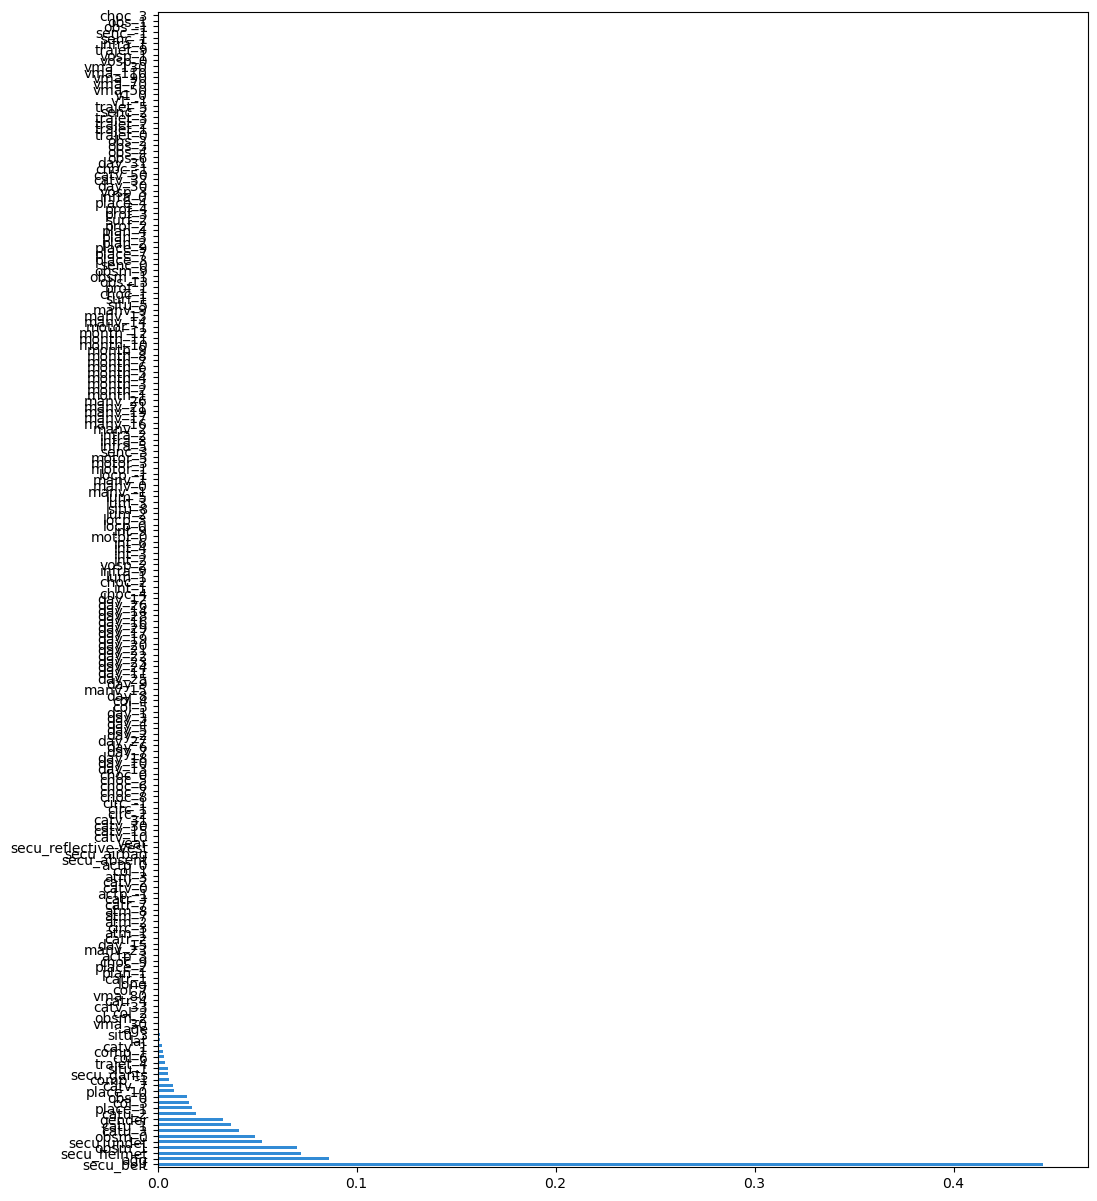

In [94]:
plt.rcParams['figure.figsize'] = (12,15)
plots = interpreter.feature_importance.plot_feature_importance(
    model, ascending=True)

- ### SHAP

In [95]:
import xgboost as xgb
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# We rebuild the same model but with numpy arrays to avoid problems with LIME due to the name of features
xgc_np = xgb.XGBClassifier(n_estimators=1000, max_depth=6, colsample_bytree = 0.8,
                           objective='binary:logistic', eval_metric="logloss", learning_rate=0.001,
                          subsample = 1.0)
xgc_np.fit(X_train.values, y_train)


exp = LimeTabularExplainer(X_test.values, feature_names=list(X_test.columns),
                           class_names=['Unharmed', 'Killed/Injuried'])

# Retrieval of predictions
probs = bst.predict(dtrain)
preds = [0 if x < 0.5 else 1 for x in probs]

# Model training
sg_clf = DecisionTreeClassifier()
sg_clf.fit(X_train, preds)

# Model scores
sg_clf.score(X_test, y_test)
print(classification_report(y_test, sg_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.55      0.63     37438
           1       0.72      0.87      0.79     51122

    accuracy                           0.73     88560
   macro avg       0.74      0.71      0.71     88560
weighted avg       0.73      0.73      0.72     88560



[22:40:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 87387/88560 [00:57<00:00]        

Expected Value: 0.5555598024611297


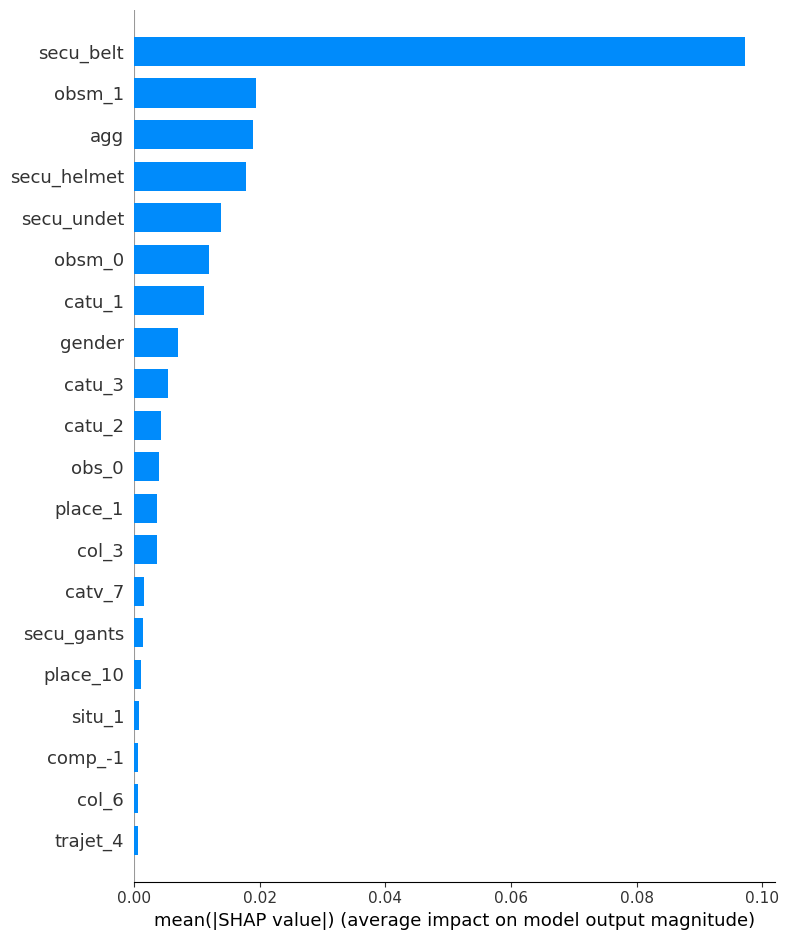

In [96]:
# Let's analyze the predictions of our model with SHAP
import shap
explainer = shap.TreeExplainer(
    bst, data=X_train[:10], model_output="probability")
shap_values = explainer.shap_values(X_test)

print('Expected Value:', explainer.expected_value)

#pd.DataFrame(shap_values).head()

# We display the features importances
summary_plot = shap.summary_plot(shap_values, X_test, plot_type="bar")

In [97]:
# Let's display local interpretation for one user
user = 2
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[user, :], X_test.iloc[user, :])

## __7. Dense Neural Network (DNN)__

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Recall # We are interested into measure the Recall of the DNN output
from keras.layers import Dropout # For applying Dropout

# Initialisation of the ANN
ann = Sequential()

# Adding the input layer to the ANN
'''
For the input layer we use input_dim to specify the total dimension of the features matrix,
which in this case is X_train.shape[1]. We add the first layer to the classifier using
the activation function 'relu' (linear unitary classifier).
'''
ann.add(Dense(units = 32, kernel_initializer = "uniform",  
                     activation = "relu", input_dim = X_train.shape[1], name='Input')) # Using the RELU function

# Second layer
ann.add(Dense(units = 64, kernel_initializer = "uniform",  activation = "relu", name='Layer_1'))

# Third layer
ann.add(Dense(units = 128, kernel_initializer = "uniform",  activation = "relu", name='Layer_2'))

# Fourth layer
ann.add(Dense(units = 128, kernel_initializer = "uniform",  activation = "relu", name='Layer_3'))

# Output layer
'''
For the output layer, we use the activation function 'sigmoid' instead of the linear rectifier (relu).
This is because in the output we are searching for a probability, as we want to determine the chance for a user implied in
an accident to be unharmed or require hospitalisation/being killed. If we want a classification we could apply a 'step' function.
In case we need to classify 3 categories, in the output layer we should speciy more than 1 node (3 in this case) and the
'sigmoid' function would not be appropiate, instead, we would require to use a rectifier or a step.
'''
ann.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name='Output')) # Using the activation function as a sigmoid to turn into probabilities

# Compiling the ANN
''' 
By default, the optimiser is 'adam'. The loss function allows to minimise the error between prediction and data.
We might use the least squared instead, depending whether the variable is ordinal or nominal. In this case, we use
binary crossentropy to estimate the difference between dependent variables as we only have 1 and 0 in the target variable.
''' 
ann.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = [Recall()])

print(ann.summary())

# Training the ANN
'''
We apply the defined callbacks to reduce learning rate and early stop the DNN in case the accuracy of the model does not vary
'''
early_stopping = EarlyStopping(
    patience=5, # Wait for 5 epochs before implementation
    min_delta = 0.01, # if after 5 epochs the loss function does not vary by 5%,
    # whether it's an increase or decrease, we stop.
    verbose = 1, # To display at which epoch we stop
    mode = 'min',
    monitor='recall')

reduce_learning_rate = ReduceLROnPlateau(
    monitor = "loss",
    patience = 3, # If recall stagnates for 3 consecutive epochs based on the ep
    episilon = 0.01,
    factor = 0.1, # We reduce the learning rate by a factor of 0.1
    cooldown = 2, # We wait for 4 epochs before repeating
    verbose = 1)

training_history = ann.fit(X_train, y_train,  batch_size = 32, epochs = 20,
                          callbacks=[reduce_learning_rate])

# Making the predictions with the ANN
y_pred  = ann.predict(X_test)

path_to_file = "../models/DNN_model.keras"
print('Model saved at:',path_to_file)
ann.save(path_to_file)

2023-12-01 15:08:42.214310: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 15:08:42.232868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 15:08:42.232894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 15:08:42.233833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 15:08:42.238360: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 15:08:42.238960: I tensorflow/core/platform/cpu_feature_guard.cc:1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 32)                6560      
                                                                 
 Layer_1 (Dense)             (None, 64)                2112      
                                                                 
 Layer_2 (Dense)             (None, 128)               8320      
                                                                 
 Layer_3 (Dense)             (None, 128)               16512     
                                                                 
 Output (Dense)              (None, 1)                 129       
                                                                 
Total params: 33633 (131.38 KB)
Trainable params: 33633 (131.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-01 15:08:43.801385: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


None
Epoch 1/20


2023-12-01 15:08:44.626620: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 578113152 exceeds 10% of free system memory.


11070/11070 [==============================] - 9s 793us/step - loss: 0.4511 - recall: 0.8089 - lr: 0.0010
Epoch 2/20
11070/11070 [==============================] - 9s 775us/step - loss: 0.4357 - recall: 0.8117 - lr: 0.0010
Epoch 3/20
11070/11070 [==============================] - 9s 787us/step - loss: 0.4310 - recall: 0.8176 - lr: 0.0010
Epoch 4/20
11070/11070 [==============================] - 9s 770us/step - loss: 0.4279 - recall: 0.8164 - lr: 0.0010
Epoch 5/20
11070/11070 [==============================] - 9s 787us/step - loss: 0.4255 - recall: 0.8174 - lr: 0.0010
Epoch 6/20
11070/11070 [==============================] - 8s 756us/step - loss: 0.4238 - recall: 0.8192 - lr: 0.0010
Epoch 7/20
11070/11070 [==============================] - 9s 770us/step - loss: 0.4223 - recall: 0.8210 - lr: 0.0010
Epoch 8/20
11070/11070 [==============================] - 8s 764us/step - loss: 0.4212 - recall: 0.8214 - lr: 0.0010
Epoch 9/20
11070/11070 [==============================] - 9s 787us/step - l

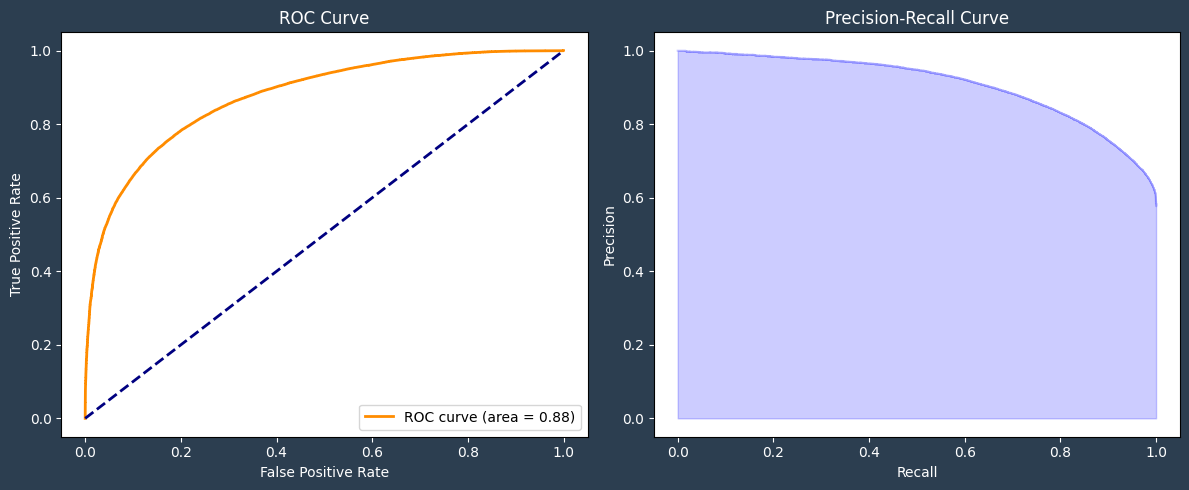

In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax = ax.ravel()

ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlabel('False Positive Rate', color='white'); ax[0].set_ylabel('True Positive Rate', color='white')
ax[0].set_title('ROC Curve', color='white')
ax[0].legend(loc='lower right')

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
ax[1].fill_between(recall, precision, step='post', alpha=0.2, color='b')
ax[1].set_xlabel('Recall', color='white'); ax[1].set_ylabel('Precision', color='white')
ax[1].set_title('Precision-Recall Curve', color='white')

ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

# Setting the background color into black
fig.patch.set_facecolor('#2c3e50')

plt.tight_layout()
plt.savefig('../plots/DNN_ROC_curve.png', bbox_inches='tight', dpi = 150)

In [8]:
# So now, depending on how much conservatives we want to be, we need to convert the probabilities in y_pred to
# chances of being hospitalised/killed
y_pred_new = (y_pred>=0.35) # If the probability is >= 35%, then we consider the user has been minor injuried/hospitalised/killed
y_pred_new = y_pred_new[:,0]

# Cross tab
cross_tab = pd.crosstab(y_test, y_pred_new, rownames=['Actual'], colnames=['Predicted'])

from sklearn.metrics import accuracy_score
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_new)

# Calculate accuracy score on the test data
class_report = classification_report_imbalanced(y_test, y_pred_new)

# Print the confusion matrix (cross_tab) and the accuracy score
print('=========================')
print("Cross-tab:\n",cross_tab)
print('\n=========================')
print('Classification report:\n',class_report)

# By considering the probability of being injured of 20%, we achieve a recall of 0.97, which is actually quite high even if the precision is not very good.
# We don't really mind about the low recall on category 0 (0.34) as we want to guarantee that we are able to properly predict each case that has been injured in any way.

Cross-tab:
 Predicted  False  True 
Actual                 
0          23281  14157
1           5447  45675

Classification report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.62      0.89      0.70      0.75      0.54     37438
          1       0.76      0.89      0.62      0.82      0.75      0.57     51122

avg / total       0.78      0.78      0.74      0.77      0.75      0.56     88560



### Model interpretation using SHAP

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Expected Value: tf.Tensor([0.60971314], shape=(1,), dtype=float32)


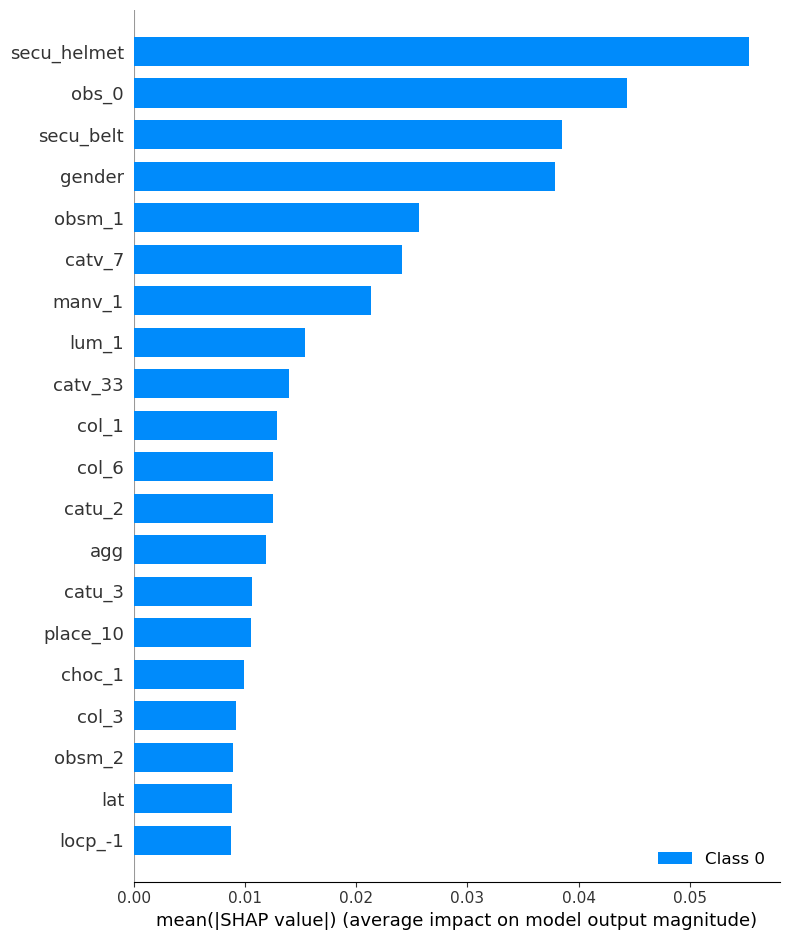

In [103]:
# Let's analyze the predictions of our model with SHAP
import shap

# Convert your input data to a NumPy array with float32 data type
X_train_np = np.array(X_train.values, dtype=np.float32)
X_test_np  = np.array(X_test.values, dtype=np.float32)

# Using ANN on the SHAP DeepExplainer
explainer   = shap.DeepExplainer(model=ann, data=X_train_np[:100])
shap_values = explainer.shap_values(X_test_np)

print('Expected Value:', explainer.expected_value)

# We display the features importances
summary_plot = shap.summary_plot(shap_values, X_test, plot_type="bar")

In [106]:
# Let's display local interpretation for one user
user = 1
shap.initjs()
shap.force_plot(explainer.expected_value.numpy()[0], shap_values[0][user, :], X_test.iloc[user, :])